# SST time series by basin

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45423,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:40295,Total threads: 4
Dashboard: /proxy/42657/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:41611,


In [3]:
session_CM2  = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [6]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

#### Load SST

In [7]:
def get_SST(expt, session, region=0, time_flag=0, start_time='0001-01-01', end_time='0009-12-31', frequency='1 monthly'):
    
    """
    region=0: global
    region=1: NA
    region=2: SO
    region=3: NP
    
    time_flag=0: annual average
    time_flag=1: monthly data
    """
    
    sst = cc.querying.getvar(expt, 'temp', session, start_time=start_time, end_time=end_time, frequency=frequency) - 273.15 # in C
    sst = sst.sel(time=slice(start_time, end_time))
    sst = sst.sel(st_ocean=0, method='nearest')
    if time_flag == 0:
        sst = sst.groupby('time.year').mean(dim='time')
    
    sst = sst.rename("sst")
    #sst = sst.attrs["units"] = "deg C"
    
    if region == 0:
        lat_slice = slice(-90, 65)
        sst = sst.sel(yt_ocean=lat_slice)
    if region == 1:
        #lat_slice = slice(40,65)
        #lon_slice = slice(-99,25)
        lat_slice = slice(25,60) # Van Oldenborgh 2009
        lon_slice = slice(-75,-7)
        sst = sst.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    if region == 2:
        lat_slice = slice(-90,-34)
        sst = sst.sel(yt_ocean=lat_slice)
    if region == 3:
        lat_slice = slice(40, 65)
        lon_slice = slice(-235, -120)
        sst = sst.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
        
    sst = sst.mean('xt_ocean').mean('yt_ocean').compute()
    
    return sst

#### North Atlantic

In [9]:
%%time
sst_CM2_025 = get_SST(expt_CM2_025, session_CM2, region=1, start_time='0001-01-01', end_time='0099-12-31')

CPU times: user 23.8 s, sys: 1.23 s, total: 25 s
Wall time: 36.3 s


In [10]:
sst_CM2_025_100_199 = get_SST(expt_CM2_025, session_CM2, region=1, start_time='0100-01-01', end_time='0199-12-31')

In [11]:
sst_CM2_025_200_299 = get_SST(expt_CM2_025, session_CM2, region=1, start_time='0200-01-01', end_time='0299-12-31')

In [12]:
sst_CM2_025_300_399 = get_SST(expt_CM2_025, session_CM2, region=1, start_time='0300-01-01', end_time='0399-12-31')

In [13]:
sst_CM2_025_400_499 = get_SST(expt_CM2_025, session_CM2, region=1, start_time='0400-01-01', end_time='0499-12-31')

In [14]:
# Concat annual data
data = xr.concat([sst_CM2_025, sst_CM2_025_100_199, sst_CM2_025_200_299, sst_CM2_025_300_399, sst_CM2_025_400_499], dim="year")

In [17]:
data.to_netcdf(path_to_data + 'SST_NA_annual.nc')

Detrend time series

In [7]:
data = xr.open_dataarray(path_to_data + 'SST_NA_annual.nc')

In [8]:
# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [9]:
data_detrend = detrend_dim(data, 'year')

In [10]:
data_detrend.to_netcdf(path_to_data + 'amo_index.nc')

Plotting

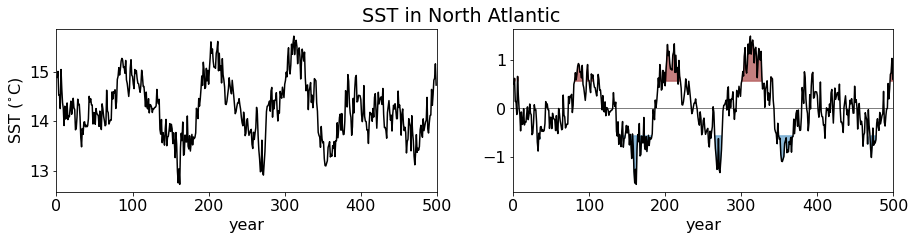

In [62]:
fig = plt.figure(figsize=(15,3))
plt.suptitle('SST in North Atlantic')

plt.subplot(121)
data.plot(color='k')
plt.title('')
plt.ylabel('SST ($^{\circ}$C)')
plt.xlim(0, 500)

plt.subplot(122)
data_detrend.plot(color='k', zorder=3)
plt.axhline(0, color='k', linewidth=0.5)
plt.fill_between(data_detrend.year, data_detrend.std(), data_detrend, where=data_detrend>data_detrend.std(), alpha=0.5, color='darkred')
plt.fill_between(data_detrend.year, -data_detrend.std(), data_detrend, where=data_detrend<-data_detrend.std(), alpha=0.5, color='C0')
plt.title('')
plt.xlim(0, 500)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_SST_NA_AMO_timeseries.png'
    plt.savefig(fig_path + fig_name);

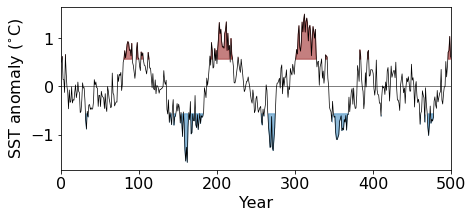

In [16]:
fig = plt.figure(figsize=(7,3))
data_detrend.plot(color='k', zorder=3, linewidth=0.7)
plt.axhline(0, color='k', linewidth=0.5)
plt.fill_between(data_detrend.year, data_detrend.std(), data_detrend, where=data_detrend>data_detrend.std(), alpha=0.5, color='darkred')
plt.fill_between(data_detrend.year, -data_detrend.std(), data_detrend, where=data_detrend<-data_detrend.std(), alpha=0.5, color='C0')
plt.title('')
plt.xlim(0, 500)
plt.xlabel('Year')
plt.ylabel('SST anomaly ($^{\circ}$C)')

# Finished
save_flag = 0
if save_flag == 1:
    fig_name = 'Fig_SST_NA_AMO_timeseries_phases.png'
    plt.savefig(fig_path + fig_name);

Years when SST is in std environment -> use for composite plots

In [17]:
year_pos_amo = data_detrend.year.where(data_detrend > data_detrend.std()).dropna(dim='year')
year_neg_amo = data_detrend.year.where(data_detrend < -data_detrend.std()).dropna(dim='year')

In [60]:
year_pos_amo
# Possibly want to remove year 2 and 6 as it is so close to the model initilisation

<xarray.DataArray 'year' (year: 87)>
array([  2.,   6.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  97.,  98.,  99., 100., 103., 104., 105., 112., 113.,
       191., 193., 194., 197., 199., 201., 202., 203., 204., 205., 206.,
       207., 208., 209., 210., 211., 212., 213., 214., 215., 216., 218.,
       219., 220., 227., 231., 301., 302., 303., 304., 305., 306., 307.,
       308., 309., 310., 311., 312., 313., 314., 315., 316., 317., 318.,
       319., 320., 321., 322., 323., 324., 325., 326., 327., 334., 339.,
       340., 341., 383., 384., 393., 394., 496., 497., 498., 499.])
Coordinates:
    st_ocean  float64 1.152
  * year      (year) int64 2 6 81 82 83 84 85 86 ... 384 393 394 496 497 498 499

In [61]:
year_neg_amo

<xarray.DataArray 'year' (year: 76)>
array([ 32.,  33.,  35., 137., 139., 141., 142., 145., 146., 147., 153.,
       155., 156., 158., 159., 160., 161., 162., 163., 165., 167., 168.,
       169., 170., 171., 173., 174., 175., 176., 177., 179., 180., 181.,
       182., 257., 258., 260., 266., 267., 268., 269., 270., 271., 272.,
       273., 274., 347., 350., 351., 352., 353., 354., 355., 356., 357.,
       358., 359., 360., 361., 362., 363., 364., 365., 366., 367., 368.,
       410., 460., 466., 470., 471., 472., 474., 475., 476., 477.])
Coordinates:
    st_ocean  float64 1.152
  * year      (year) int64 32 33 35 137 139 141 142 ... 471 472 474 475 476 477

Spectrum of detrended SST

In [54]:
def get_spectrum(data):
    sampling_rate = 1
    fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    
    return frequency, power_spectrum

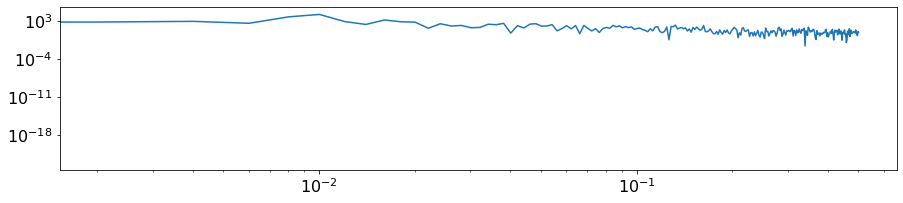

In [55]:
freq, ps = get_spectrum(data_detrend)

fig = plt.figure(figsize=(15,3))

plt.loglog(freq, ps)

### Composite plot

SST, mld, sic (contour)

In [7]:
area_t025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)

In [8]:
geolon_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [9]:
year_pos_amo = [  2,   6,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  97,  98,  99, 100, 103, 104, 105, 112, 113,
       191, 193, 194, 197, 199, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218,
       219, 220, 227, 231, 301, 302, 303, 304, 305, 306, 307,
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 334, 339,
       340, 341, 383, 384, 393, 394, 496, 497, 498, 499]

year_neg_amo = [ 32,  33,  35, 137, 139, 141, 142, 145, 146, 147, 153,
       155, 156, 158, 159, 160, 161, 162, 163, 165, 167, 168,
       169, 170, 171, 173, 174, 175, 176, 177, 179, 180, 181,
       182, 257, 258, 260, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 347, 350, 351, 352, 353, 354, 355, 356, 357,
       358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       410, 460, 466, 470, 471, 472, 474, 475, 476, 477]

year_pos_amo_minus1 = [ii-1 for ii in year_pos_amo]
year_neg_amo_minus1 = [ii-1 for ii in year_neg_amo]

In [10]:
start_time = '0001-01-01'
end_time   = '0499-12-31'
lon_slice = slice(-75,25)
lat_slice = slice(40,90)

Load previously calculated composites

In [20]:
sst_pos = xr.open_dataarray(path_to_data + 'sst_pos_NA_composite_CM2_025.nc')
sst_neg = xr.open_dataarray(path_to_data + 'sst_neg_NA_composite_CM2_025.nc')

In [21]:
mld_pos = xr.open_dataarray(path_to_data + 'mld_pos_NA_composite_CM2_025.nc')
mld_neg = xr.open_dataarray(path_to_data + 'mld_neg_NA_composite_CM2_025.nc')

In [27]:
aice_pos = xr.open_dataarray(path_to_data + 'aice_pos_composite_CM2_025.nc')
aice_neg = xr.open_dataarray(path_to_data + 'aice_neg_composite_CM2_025.nc')

Set correct geolon, geolat

In [52]:
aice_pos = aice_pos.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

In [54]:
aice_neg = aice_neg.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

In [55]:
sst_pos = sst_pos.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
sst_neg = sst_neg.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

In [56]:
mld_pos = mld_pos.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
mld_neg = mld_neg.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

Plotting

In [25]:
CLEX_CobaldBlue = '#0066B3'

In [36]:
# Use cartopy land for now (option to update to model land but will change with resolution)
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='darkgrey', linewidth=0.5)
import cartopy.crs as ccrs

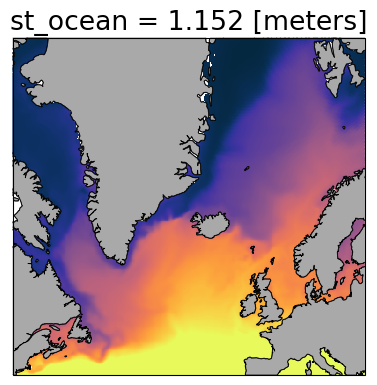

In [59]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1, projection=ccrs.Mercator(central_longitude=-25, min_latitude=40, max_latitude=80))

ax.set_extent([-75, 25, 40, 80])
sst_pos.plot(x='geolon_t', y='geolat_t', vmin=-2,vmax=15, cmap=cm.cm.thermal, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)

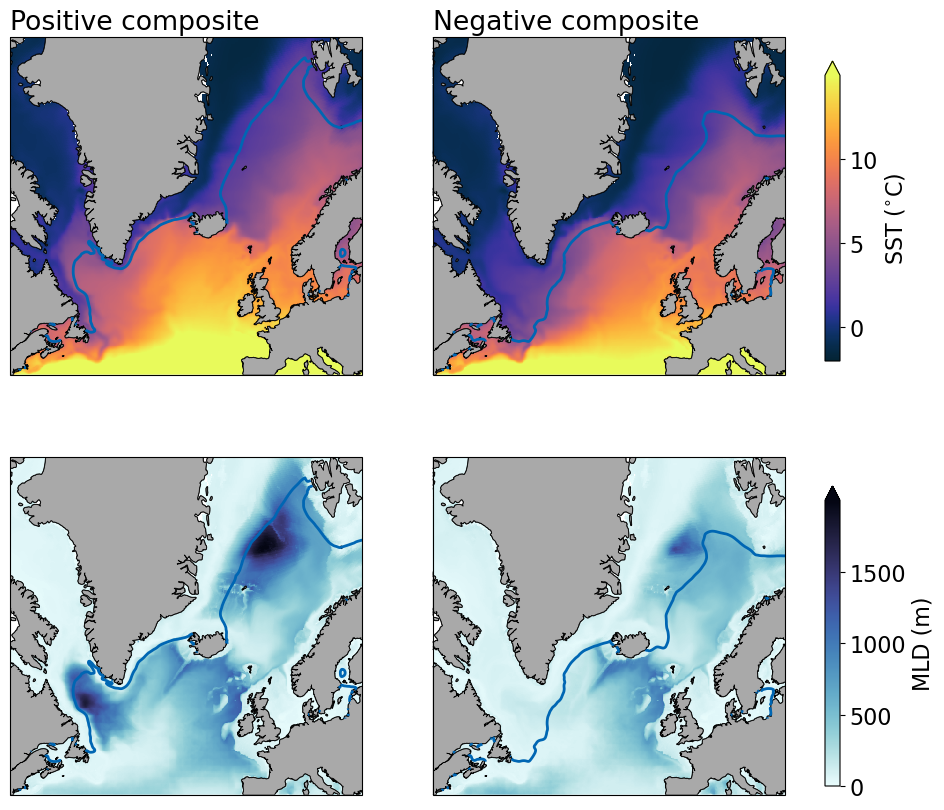

In [80]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2, 2, 1, projection=ccrs.Mercator(central_longitude=-25, min_latitude=40, max_latitude=80))
ax.set_extent([-75, 25, 40, 80])
plt.title('Positive composite', loc='left')
sc = sst_pos.plot(x='geolon_t', y='geolat_t', vmin=-2,vmax=15, cmap=cm.cm.thermal, transform=ccrs.PlateCarree(), add_colorbar=False)
aice_pos.max('month').plot.contour(x='geolon_t', y='geolat_t', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.tick_params(labelbottom=False)
plt.xlabel('')
plt.ylabel('Latitude')

ax = fig.add_subplot(2, 2, 2, projection=ccrs.Mercator(central_longitude=-25, min_latitude=40, max_latitude=80))
ax.set_extent([-75, 25, 40, 80])
plt.title('Negative composite', loc='left')
sst_neg.plot(x='geolon_t', y='geolat_t', vmin=-2,vmax=15, cmap=cm.cm.thermal, transform=ccrs.PlateCarree(), add_colorbar=False)
aice_neg.max('month').plot.contour(x='geolon_t', y='geolat_t', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('')
plt.ylabel('')

# Colorbar
cbar_ax = fig.add_axes([0.94, 0.55, 0.015, 0.3])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(0,15,5), extend=('max'))
cbar.set_label('SST ($^{\circ}$C)')

ax = fig.add_subplot(2, 2, 3, projection=ccrs.Mercator(central_longitude=-25, min_latitude=40, max_latitude=80))
ax.set_extent([-75, 25, 40, 80])
sc = mld_pos.max('month').plot(x='geolon_t', y='geolat_t', vmin=0, vmax=2000, cmap=cm.cm.ice_r, transform=ccrs.PlateCarree(), add_colorbar=False)
aice_pos.max('month').plot.contour(x='geolon_t', y='geolat_t', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax = fig.add_subplot(2, 2, 4, projection=ccrs.Mercator(central_longitude=-25, min_latitude=40, max_latitude=80))
ax.set_extent([-75, 25, 40, 80])
mld_neg.max('month').plot(x='geolon_t', y='geolat_t', vmin=0, vmax=2000, cmap=cm.cm.ice_r, transform=ccrs.PlateCarree(), add_colorbar=False)
aice_neg.max('month').plot.contour(x='geolon_t', y='geolat_t', levels=[0.15], colors=CLEX_CobaldBlue, linewidths=2, transform=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.tick_params(labelleft=False)
plt.ylabel('')
plt.xlabel('Longitude')

# Colorbar
cbar_ax = fig.add_axes([0.94, 0.125, 0.015, 0.3])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(0,2000,500), extend=('max'))
cbar.set_label('MLD (m)')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_composites_NA_maps.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');

---
Calculate and save composites

SST

In [ ]:
sst = cc.querying.getvar(expt_CM2_025, 'temp', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly') - 273.15 # in C
# Time slice
sst = sst.sel(time=slice(start_time, end_time))
# Surface temperature
sst = sst.sel(st_ocean=0, method='nearest')
# North Atlantic
sst = sst.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Annual average
sst = sst.groupby('time.year').mean(dim='time')
# Update units
sst = sst.rename("sst")
#sst = sst.attrs["units"] = "deg C"
# Select composites
sst_pos = sst[year_pos_amo_minus1,...].mean('year')
sst_neg = sst[year_neg_amo_minus1,...].mean('year')

In [35]:
sst_pos = sst_pos.load()
sst_neg = sst_neg.load()

MLD

In [ ]:
mld = cc.querying.getvar(expt_CM2_025, 'mld', session_CM2, start_time=start_time, end_time=end_time, frequency='1 monthly')
# Time slice
mld = mld.sel(time=slice(start_time, end_time))
# North Atlantic
mld = mld.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# Select composite years
mld_pos = mld.sel(time=mld.time.dt.year.isin(year_pos_amo_minus1))
mld_neg = mld.sel(time=mld.time.dt.year.isin(year_neg_amo_minus1))
# Climatology
mld_pos = mld_pos.groupby('time.month').mean(dim='time')
mld_neg = mld_neg.groupby('time.month').mean(dim='time')

Sea ice

In [11]:
from datetime import timedelta

In [12]:
def get_aice_composite(composite):
    
    for ii in composite:
        print(ii)
        if ii < 10:
            syear = '000' + str(ii)
        if (ii > 9) & (ii<100):
            syear = '00' + str(ii)
        if ii > 99:
            syear = '0' + str(ii)

        if ii+1 < 10:
            eyear = '000' + str(ii+1)
        if (ii+1 > 9) & (ii+1<100):
            eyear = '00' + str(ii+1)
        if ii+1 > 99:
            eyear = '0' + str(ii+1)

        start_time = syear + '-01-01'
        end_time_1 = syear + '-12-31'
        end_time_2 = eyear + '-01-31'

        aice = cc.querying.getvar(expt_CM2_025, 'aice', session_CM2, frequency='1 monthly', start_time=start_time, end_time=end_time_2)
        
        # Shift time to make sure it is in the correct month
        aice['time'] = aice.time.to_pandas() - timedelta(hours = 12) 
        aice = aice.sel(time=slice(start_time, end_time_1))

        # Change lat, lon names to match ocean model convention, select North Atlantic
        aice.coords['ni'] = area_t025['xt_ocean'].values
        aice.coords['nj'] = area_t025['yt_ocean'].values
        aice = aice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
        aice = aice.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

        # Concatenate years
        if ii == composite[0]:
            aice_comp = aice
        else:
            aice_comp = xr.concat([aice_comp, aice], dim='time')

    return aice_comp

In [ ]:
%%time   
# 23 min
aice_pos = get_aice_composite(year_pos_amo_minus1)

In [16]:
# Climatology
aice_pos = aice_pos.groupby('time.month').mean(dim='time')

In [ ]:
aice_pos.to_netcdf(path_to_data + 'aice_pos_composite_CM2_025.nc')

In [ ]:
%%time
# 15 min
aice_neg = get_aice_composite(year_neg_amo_minus1)

In [16]:
# Climatology
aice_neg = aice_neg.groupby('time.month').mean(dim='time')

In [17]:
aice_neg.to_netcdf(path_to_data + 'aice_neg_composite_CM2_025.nc')